In [ ]:
EXP_ID = "v4_h4_thr0p5pct_tolerant0p3pct"


In [ ]:
import sys
from pathlib import Path

cwd = Path.cwd()
project_root = cwd
while not (project_root / "src").is_dir():
    if project_root.parent == project_root:
        raise RuntimeError("Projektwurzel mit 'src' nicht gefunden.")
    project_root = project_root.parent

print("Erkannte Projektwurzel:", project_root)
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


In [ ]:
import json
from pathlib import Path

# EXP_ID kommt aus der Konfigurationszelle oberhalb
exp_meta_dir = project_root / "data" / "processed" / "experiments"
exp_config_path = exp_meta_dir / f"{EXP_ID}_config.json"

with exp_config_path.open("r", encoding="utf-8") as f:
    exp_config = json.load(f)

print("Geladene Experiment-Konfiguration:", exp_config)


## Allgemeine Beschreibung

Dieses Notebook trainiert ein **Zwei‑Stufen‑Modell mit XGBoost**, das aus News‑ und Kursdaten für EURUSD
zwei Entscheidungen ableitet:

1. **Signal (Stufe 1)**  
   Vorhersage, ob es im betrachteten Horizont eine signifikante Bewegung gibt (`move`)  
   oder ob der Kurs als `neutral` eingestuft wird.  
   → Zielvariable: `signal` (0 = neutral, 1 = Bewegung)

2. **Richtung (Stufe 2)**  
   Falls eine Bewegung vorhergesagt wird, Vorhersage der Bewegungsrichtung: `up` oder `down`.  
   → Zielvariable: `direction` (0 = down, 1 = up, nur für Tage mit `signal == 1`)

Die Label‑Logik (Horizont, Schwellen, Monotonie‑Bedingung) und der konkrete Trainingsdatensatz
werden im Notebook  
`notebooks/1_data_prep_xgboost_two_stage.ipynb`  
über eine **Experiment-ID (`EXP_ID`)** festgelegt. Dieses Notebook verwendet den Datensatz, der dort
für das aktuelle Experiment erzeugt wurde.

Die wichtigsten Bausteine sind:

- vorbereiteter Trainingsdatensatz mit:
  - Kursdaten (z. B. `Close`, `High`, `Low`, `Open`),
  - News‑Tagesfeatures (z. B. `article_count`, `avg_polarity`, `avg_neg`, `avg_neu`, `avg_pos`),
  - abgeleiteten Features (z. B. Candle‑Features, Kalender‑Features, Sentiment‑Anteile),
  - Zielvariablen `label`, `signal`, `direction`.
- ein zeitlicher Split in **Train**, **Validation** und **Test**,
- zwei XGBoost‑Modelle:
  - Stufe 1: binär (`neutral` vs. `move`),
  - Stufe 2: binär (`down` vs. `up`, nur auf Bewegungstagen),
- Auswertung in Form von Accuracy, Precision, Recall, F1 und Konfusionsmatrizen,
- Speicherung der wichtigsten Kennzahlen in einer JSON‑Datei, um verschiedene Experimente
  später vergleichen zu können.


## Experiment-Metadaten (v1_h4_thr0p5pct_strict)

**Allgemein**

- `EXP_ID`: `v2_h4_thr0p5pct_strict`
- Zweck: erste Zwei‑Stufen‑Konfiguration mit 4‑Tage‑Horizont und ±0.5 %‑Schwellen,
  streng monotonem Kursverlauf.
- Data‑Prep‑Notebook: `notebooks/1_data_prep_xgboost_two_stage.ipynb`

**Label-Definition (im Data-Prep angewendet)**

- Datengrundlage: `data/raw/fx/EURUSDX.csv` (Tages‑OHLCV für EURUSD)
- Horizont: `horizon_days = 4` (Tage `t` bis `t+4`)
- Schwellen:
  - `up_threshold = +0.005` (entspricht +0.5 % Lookahead‑Return)
  - `down_threshold = -0.005` (entspricht −0.5 % Lookahead‑Return)
- Pfadbedingung:
  - `strict_monotonic = True`
  - `up`: Kurs steigt an jedem Zwischentag (alle täglichen Differenzen > 0)
  - `down`: Kurs fällt an jedem Zwischentag (alle täglichen Differenzen < 0)
- Label `label`:
  - `up`, `down` oder `neutral` je nach obiger Logik

**Abgeleitete Zielvariablen im Trainingsdatensatz**

- `signal`:
  - `0` = neutral
  - `1` = Bewegung (up oder down)
- `direction`:
  - `0` = down
  - `1` = up
  - `NaN` = neutral (wird im Richtungs‑Modell nicht verwendet)

**Datenquellen und Pfade**

- Label-Dateien:
  - aktuelle Version: `data/processed/fx/eurusd_labels.csv`
  - Experiment-Version: `data/processed/fx/eurusd_labels__v1_h4_thr0p5pct_strict.csv`
- Trainingsdatensätze:
  - aktuelle Version: `data/processed/datasets/eurusd_news_training.csv`
  - Experiment-Version: `data/processed/datasets/eurusd_news_training__v1_h4_thr0p5pct_strict.csv`
- Im Trainings‑Notebook wird aktuell `eurusd_news_training.csv` geladen,
  das aus der Experiment‑Version erzeugt wurde.

**Zeitliche Splits (Train/Val/Test)**

- Test‑Start: `test_start = "2025-01-01"`
  - alle Daten mit `date >= 2025-01-01` → Test‑Split
  - alle Daten davor → Grundlage für Train/Val
- Aufteilung vor Test‑Start:
  - `train_frac_within_pretest = 0.8`
  - 80 % der früheren Daten → Training
  - 20 % der früheren Daten → Validation

**XGBoost-Konfiguration (für beide Stufen)**

_Gemeinsame Einstellungen_

- `objective = "binary:logistic"`
- `eval_metric = "logloss"`
- `max_depth = 3`
- `learning_rate = 0.05`
- `n_estimators = 400`
- `subsample = 0.9`
- `colsample_bytree = 0.9`
- `random_state = 42`
- `early_stopping_rounds = 50`
- Entscheidungsgrenze:
  - Standard‑Threshold `0.5` für die Umwandlung von Wahrscheinlichkeiten → Klasse

_Stufe 1 – Signal-Modell (`signal`: 0 = neutral, 1 = move)_

- Klassenverteilung: stark unausgeglichen (viel mehr `neutral` als `move`)
- `scale_pos_weight`:
  - automatisch gesetzt auf `N_neg / N_pos` des Trainingssplits,
  - sorgt dafür, dass `signal = 1` stärker gewichtet wird.

_Stufe 2 – Richtungs-Modell (`direction`: 0 = down, 1 = up)_

- Datenbasis: nur Zeilen mit `signal == 1` (Bewegungstage)
- `scale_pos_weight = 1.0`
  - aktuell werden `down` und `up` gleich gewichtet.

**Verwendete Features (`FEATURE_COLS`)**

- News‑Features:
  - `article_count` – Anzahl der News pro Tag
  - `avg_polarity` – mittlerer Sentiment‑Score (gesamt)
  - `avg_neg` – mittlerer negativer Sentiment‑Anteil
  - `avg_neu` – mittlerer neutraler Sentiment‑Anteil
  - `avg_pos` – mittlerer positiver Sentiment‑Anteil
  - `pos_share` – `avg_pos / (avg_pos + avg_neg)`
  - `neg_share` – `avg_neg / (avg_pos + avg_neg)`
- Kurs‑ und Kalender‑Features:
  - `intraday_range_pct` – (High − Low) / Close (Tages‑Volatilität)
  - `upper_shadow` – High minus Kerzenkörper (oberer Docht)
  - `lower_shadow` – Kerzenkörper minus Low (untere Lunte)
  - `month` – Monat (1–12)
  - `quarter` – Quartal (1–4)

**Ergebnis-Speicherung**

- JSON-Datei mit allen Metriken:
  - aktueller Pfad (Stand Baseline‑Notebook): `results/two_stage_v0_h4_thr1pct_strict.json`
  - Für dieses Experiment sollte eine eigene Datei verwendet werden, z. B.:
    - `results/two_stage__v1_h4_thr0p5pct_strict.json`
  - Inhalt:
    - Abschnitt `config` mit Label‑ und Datensatz‑Parametern,
    - Abschnitt `signal` (Metriken für Stufe 1),
    - Abschnitt `direction` (Metriken für Stufe 2),
    - Abschnitt `combined_test` (3‑Klassen‑Auswertung `neutral/up/down`).


In [ ]:
import sys
from pathlib import Path

# Aktuelles Arbeitsverzeichnis des Kernels ausgeben
cwd = Path.cwd()
print("Aktuelles Arbeitsverzeichnis:", cwd)

# Projektwurzel automatisch finden, indem wir nach oben laufen,
# bis ein Ordner `src` existiert. So funktioniert das Notebook
# unabhängig davon, ob es in `notebooks/` oder einem Unterordner liegt.
project_root = cwd
while not (project_root / "src").is_dir():
    project_root = project_root.parent

print("Erkannte Projektwurzel:", project_root)

# Projektwurzel in den PYTHONPATH aufnehmen, damit `import src....` funktioniert.
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

## 1. Setup und Datensatz laden

In diesem Abschnitt:

- wird der Python‑Pfad so gesetzt, dass das `src`‑Paket im Notebook importierbar ist,
- werden die Hilfsfunktionen aus `src/models/train_xgboost_two_stage.py` importiert,
- und der vorbereitete Trainingsdatensatz `eurusd_news_training.csv` geladen.

Die Daten enthalten bereits alle Kurs‑ und News‑Features sowie die Zielvariablen `label`, `signal` und `direction`.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.train_xgboost_two_stage import (
    load_dataset,
    split_train_val_test,
    build_signal_targets,
    build_direction_targets,
    train_xgb_binary,
    FEATURE_COLS,
)

plt.style.use("seaborn-v0_8")

dataset_path = project_root / "data/processed/datasets/eurusd_news_training.csv"
df = load_dataset(dataset_path)

df.head()


## 2. Klassenverteilungen untersuchen

Bevor wir Modelle trainieren, schaue ich mir an, wie die Klassen verteilt sind:

- `label` (3‑Klassen‑Ziel): `neutral`, `up`, `down`
- `signal` (Binary‑Ziel für Stufe 1): 0 = neutral, 1 = Bewegung
- `direction` (Binary‑Ziel für Stufe 2, nur bei Bewegung): 0 = down, 1 = up

Die Countplots machen die starke Klassenungleichverteilung sichtbar:
- Viele `neutral`‑Tage,
- relativ wenige Bewegungen (`up` und `down`).


In [ ]:
print("Label-Verteilung (neutral/up/down):")
print(df["label"].value_counts())

print("\nSignal-Verteilung (0=neutral, 1=move):")
print(df["signal"].value_counts())

print("\nDirection (0=down, 1=up, ohne NaN):")
print(df["direction"].value_counts(dropna=True))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(x="label", data=df, ax=axes[0])
axes[0].set_title("label")

sns.countplot(x="signal", data=df, ax=axes[1])
axes[1].set_title("signal (0/1)")

sns.countplot(x="direction", data=df[df["signal"] == 1], ax=axes[2])
axes[2].set_title("direction (nur signal=1)")

plt.tight_layout()
plt.show()


## 3. Zeitliche Train/Val/Test‑Splits

Um Data Leakage zu vermeiden, werden die Daten **chronologisch** aufgeteilt:

- **Test-Split**: alle Daten ab dem 1. Januar 2025.
- **Train+Validation**: alle Daten von 2020 bis Ende 2024, darin nochmal 80 % Train / 20 % Val.

So sieht das Modell den Testzeitraum beim Training nicht und wir erhalten eine realistische Out‑of‑Sample‑Bewertung.


In [ ]:
# Parameter für den zeitlichen Split (werden auch in die JSON-Config geschrieben)
test_start = "2025-01-01"
train_frac_pretest = 0.8  # 80 % Train, 20 % Val vor test_start

# Test ab 2025-01-01, 80/20-Split innerhalb 2020–2024
splits = split_train_val_test(
    df,
    pd.to_datetime(test_start),
    train_frac_within_pretest=train_frac_pretest,
)

for name, split_df in splits.items():
    print(f"{name}: {split_df['date'].min().date()} → {split_df['date'].max().date()} (n={len(split_df)})")


## 4. Stufe 1 – Signal‑Modell (neutral vs move)

In dieser Stufe trainiere ich ein Binary‑XGBoost‑Modell auf:

- Ziel: `signal` (0 = neutral, 1 = Bewegung up/down)
- Features: News‑Sentiment + Volatilität + Schatten + Kalender (`FEATURE_COLS`)

Wegen der starken Klassenungleichverteilung verwende ich `scale_pos_weight ≈ N_neg / N_pos`
und Early Stopping auf dem Validierungs‑Split.


In [ ]:
# Zielvariablen
y_train_signal = build_signal_targets(splits["train"])
y_val_signal = build_signal_targets(splits["val"])
y_test_signal = build_signal_targets(splits["test"])

X_train_signal = splits["train"][FEATURE_COLS]
X_val_signal = splits["val"][FEATURE_COLS]
X_test_signal = splits["test"][FEATURE_COLS]

model_signal = train_xgb_binary(
    X_train_signal, y_train_signal,
    X_val_signal, y_val_signal
)

model_signal


## 5. Stufe 1 – Qualität des Signal‑Modells

Hier werte ich das Signal‑Modell für Train/Val/Test aus:

- Accuracy,
- Confusion‑Matrix,
- Classification‑Report (Precision, Recall, F1).

Besonders wichtig sind Precision und Recall der Klasse `1` (move).


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def eval_and_plot_signal(name, model, X, y_true):
    """Evaluiert das Signal-Modell (0=neutral, 1=move) und hebt die move-Klasse hervor."""
    if len(X) == 0:
        print(f"[warn] {name} ist leer.")
        return

    # Wahrscheinlichkeiten und harte Vorhersage für Klasse 1 (move)
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(
        y_true,
        y_pred,
        target_names=["neutral", "move"],
        output_dict=True,
        digits=3,
    )

    print(f"\n=== {name.upper()} (SIGNAL) ===")
    print(f"Accuracy gesamt: {acc:.3f}")

    move_stats = report["move"]
    print(
        f"move-Klasse: precision={move_stats['precision']:.3f}, "
        f"recall={move_stats['recall']:.3f}, "
        f"f1={move_stats['f1-score']:.3f}, "
        f"support={int(move_stats['support'])}"
    )

    print("\nVollständiger Classification-Report (neutral & move):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["neutral", "move"],
        digits=3,
    ))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["neutral", "move"],
        yticklabels=["neutral", "move"],
    )
    plt.title(f"Confusion Matrix – {name} (signal)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def eval_and_plot_direction(name, model, X, y_true):
    """Evaluiert das Richtungs-Modell (0=down, 1=up) und hebt die up-Klasse hervor."""
    if len(X) == 0:
        print(f"[warn] {name} ist leer.")
        return

    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(
        y_true,
        y_pred,
        target_names=["down", "up"],
        output_dict=True,
        digits=3,
    )

    print(f"\n=== {name.upper()} (DIRECTION) ===")
    print(f"Accuracy gesamt: {acc:.3f}")

    up_stats = report["up"]
    print(
        f"up-Klasse: precision={up_stats['precision']:.3f}, "
        f"recall={up_stats['recall']:.3f}, "
        f"f1={up_stats['f1-score']:.3f}, "
        f"support={int(up_stats['support'])}"
    )

    print("\nVollständiger Classification-Report (down & up):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["down", "up"],
        digits=3,
    ))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Reds",
        xticklabels=["down", "up"],
        yticklabels=["down", "up"],
    )
    plt.title(f"Confusion Matrix – {name} (direction)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Aufrufe für beide Modelle:

eval_and_plot_signal("train", model_signal, X_train_signal, y_train_signal)
eval_and_plot_signal("val",   model_signal, X_val_signal,   y_val_signal)
eval_and_plot_signal("test",  model_signal, X_test_signal,  y_test_signal)



In [18]:
from sklearn.metrics import precision_score, recall_score

# --- Threshold-Test für das Signal-Modell (VAL) ---

# Wahrscheinlichkeiten P(signal=1) für den Val-Split
p_signal_val = model_signal.predict_proba(X_val_signal)[:, 1]

print("Signal-Thresholds auf VAL:")
for T_sig in [0.5, 0.6, 0.7]:
    y_pred_sig = (p_signal_val >= T_sig).astype(int)  # 1=move, 0=neutral
    prec = precision_score(y_val_signal, y_pred_sig, zero_division=0)
    rec = recall_score(y_val_signal, y_pred_sig, zero_division=0)
    print(f"T_signal={T_sig:.2f}  ->  precision_move={prec:.3f}, recall_move={rec:.3f}")


Signal-Thresholds auf VAL:
T_signal=0.50  ->  precision_move=0.517, recall_move=0.365
T_signal=0.60  ->  precision_move=0.800, recall_move=0.094
T_signal=0.70  ->  precision_move=0.000, recall_move=0.000


# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"])
X_val_dir, y_val_dir = build_direction_targets(splits["val"])
X_test_dir, y_test_dir = build_direction_targets(splits["test"])

# Hier bewusst kein Class-Weighting (scale_pos_weight=1.0)
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

model_dir


In [ ]:
# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"])
X_val_dir, y_val_dir = build_direction_targets(splits["val"])
X_test_dir, y_test_dir = build_direction_targets(splits["test"])

# Kein Class-Weighting nötig, Klassen relativ ausgeglichen → scale_pos_weight=1.0
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

eval_and_plot_direction("train", model_dir, X_train_dir, y_train_dir)
eval_and_plot_direction("val",   model_dir, X_val_dir,   y_val_dir)
eval_and_plot_direction("test",  model_dir, X_test_dir,  y_test_dir)


In [19]:
# --- Threshold-Test für das Richtungs-Modell (VAL, nur Move-Tage) ---

from sklearn.metrics import precision_score, recall_score

# Wahrscheinlichkeiten P(up=1) für den Val-Split (nur Move-Tage)
p_up_val = model_dir.predict_proba(X_val_dir)[:, 1]

print("Up-Thresholds auf VAL (nur Move-Tage):")
for T_up in [0.5, 0.6, 0.7]:
    y_pred_up = (p_up_val >= T_up).astype(int)  # 1=up, 0=down
    prec_up = precision_score(y_val_dir, y_pred_up, zero_division=0)
    rec_up = recall_score(y_val_dir, y_pred_up, zero_division=0)
    print(f"T_up={T_up:.2f}  ->  precision_up={prec_up:.3f}, recall_up={rec_up:.3f}")


Up-Thresholds auf VAL (nur Move-Tage):
T_up=0.50  ->  precision_up=0.821, recall_up=0.780
T_up=0.60  ->  precision_up=0.846, recall_up=0.537
T_up=0.70  ->  precision_up=0.909, recall_up=0.244


## 8. Feature‑Importance

Um besser zu verstehen, welche Merkmale die Modelle tatsächlich nutzen, schaue ich mir
die Feature‑Importances der beiden XGBoost‑Modelle an:

- **Signal‑Modell** (neutral vs move): Welche Kombination aus News‑Sentiment, Volatilität,
  Schatten und Kalender ist wichtig, um Tage mit Bewegungen von neutralen Tagen zu unterscheiden?
- **Richtungs‑Modell** (up vs down): Welche Features helfen dabei, die Richtung einer Bewegung
  vorherzusagen, sobald ein Signal erkannt wurde?

Die Balkendiagramme sortieren die Features nach absteigender Wichtigkeit, basierend auf
den vom Modell gelernten Splits.


In [ ]:
import numpy as np

def plot_feature_importance(model, title):
    importance = model.feature_importances_
    order = np.argsort(importance)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(order)), importance[order])
    plt.xticks(range(len(order)),
               [FEATURE_COLS[i] for i in order],
               rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_signal, "Feature Importance – Signal-Modell")
plot_feature_importance(model_dir, "Feature Importance – Richtungs-Modell")


## 9. Kombinierte 3‑Klassen‑Auswertung (neutral / up / down)

Zum Schluss kombiniere ich beide Stufen zu einem finalen 3‑Klassen‑Output:

1. Das Signal‑Modell entscheidet für jeden Test‑Tag:
   - `signal = 0` → endgültiges Label = `neutral`
   - `signal = 1` → es liegt eine Bewegung vor (`move`)
2. Nur wenn `signal = 1`, wird das Richtungs‑Modell aufgerufen:
   - `direction = 1` → endgültiges Label = `up`
   - `direction = 0` → endgültiges Label = `down`

Aus diesen beiden Modellen baue ich ein kombiniertes Label (`neutral`/`up`/`down`) und
vergleiche es mit der wahren `label`‑Spalte im Testzeitraum ab 2025. Die 3‑Klassen‑Confusion‑Matrix
und der Classification‑Report zeigen, wie gut das Gesamtsystem neutrale Tage von Bewegungen
und die Richtung der Bewegungen unterscheidet.


3-Klassen-Confusion-Matrix (rows=true, cols=pred):


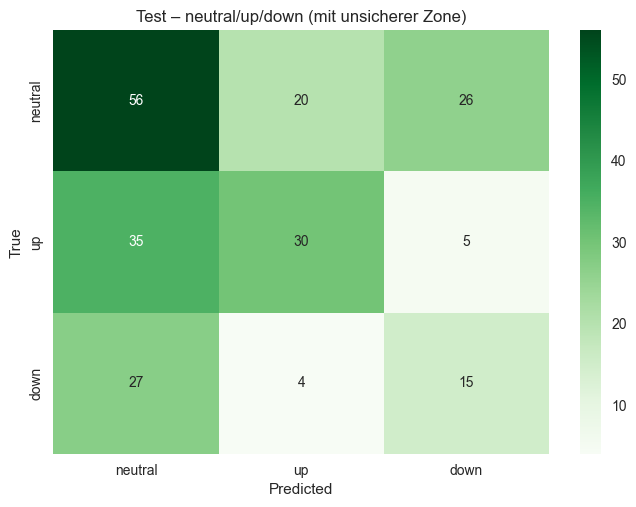


3-Klassen-Report:
              precision    recall  f1-score   support

     neutral      0.475     0.549     0.509       102
          up      0.556     0.429     0.484        70
        down      0.326     0.326     0.326        46

    accuracy                          0.463       218
   macro avg      0.452     0.435     0.440       218
weighted avg      0.469     0.463     0.462       218



In [23]:
from sklearn.metrics import classification_report, confusion_matrix

X_test_all = splits["test"][FEATURE_COLS]

# 1) Schwellen festlegen
T_signal   = 0.5   # Signal-Schwelle lassen
T_up_high  = 0.6   # sicher up
T_up_low   = 0.4   # sicher down

# 2) Wahrscheinlichkeiten berechnen
p_signal_test = model_signal.predict_proba(X_test_all)[:, 1]  # P(move)
p_up_test     = model_dir.predict_proba(X_test_all)[:, 1]     # P(up | move)

# 3) Harte Entscheidung für signal (0=neutral, 1=move)
signal_pred = (p_signal_test >= T_signal).astype(int)

# 4) Kombiniertes 3-Klassen-Label mit „unsicherer Zone“ für Richtung
#    - signal=0              -> neutral
#    - signal=1 & p_up>=high -> up
#    - signal=1 & p_up<=low  -> down
#    - signal=1 & zwischen   -> neutral (unsicher, nicht handeln)
combined_pred = []
for sig, p_up in zip(signal_pred, p_up_test):
    if sig == 0:
        combined_pred.append("neutral")
    else:
        if p_up >= T_up_high:
            combined_pred.append("up")
        elif p_up <= T_up_low:
            combined_pred.append("down")
        else:
            combined_pred.append("neutral")
combined_pred = np.array(combined_pred)

combined_true = splits["test"]["label"].to_numpy()

# 5) Auswertung wie bisher
print("3-Klassen-Confusion-Matrix (rows=true, cols=pred):")
cm3 = confusion_matrix(combined_true, combined_pred, labels=["neutral", "up", "down"])
sns.heatmap(
    cm3,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["neutral", "up", "down"],
    yticklabels=["neutral", "up", "down"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test – neutral/up/down (mit unsicherer Zone)")
plt.show()

print("\n3-Klassen-Report:")
print(classification_report(combined_true, combined_pred, labels=["neutral", "up", "down"], digits=3))


In [21]:
import numpy as np

# Wir setzen voraus:
# - combined_true, combined_pred
# - signal_pred, dir_pred (0/1) aus der kombinierten Test-Zelle
# - true down = label "down"

down_mask = combined_true == "down"
n_down = int(down_mask.sum())

n_down_signal0 = int(((signal_pred == 0) & down_mask).sum())  # als neutral abgestempelt
n_down_signal1 = int(((signal_pred == 1) & down_mask).sum())  # vom Signal-Modell erkannt

n_down_correct_dir = int(((signal_pred == 1) & (dir_pred == 0) & down_mask).sum())  # richtig "down"
n_down_wrong_up   = int(((signal_pred == 1) & (dir_pred == 1) & down_mask).sum())  # fälschlich "up"

print(f"Anzahl echter down-Tage im Test: {n_down}")
print(f"- davon vom Signal-Modell als neutral (signal=0): {n_down_signal0}")
print(f"- davon vom Signal-Modell als move  (signal=1): {n_down_signal1}")
print(f"    - davon korrekt als down erkannt: {n_down_correct_dir}")
print(f"    - davon fälschlich als up erkannt: {n_down_wrong_up}")


Anzahl echter down-Tage im Test: 46
- davon vom Signal-Modell als neutral (signal=0): 26
- davon vom Signal-Modell als move  (signal=1): 20
    - davon korrekt als down erkannt: 16
    - davon fälschlich als up erkannt: 4


## 10. Baseline-Ergebnisse speichern (v0)

Bevor ich weitere Experimente (z.B. andere Thresholds oder geänderte Label-Logik) durchführe,
möchte ich den aktuellen Stand des Zwei-Stufen-Modells festhalten.

In dieser Zelle speichere ich:

- die wichtigsten Hyperparameter / Einstellungen (Label-Logik, Features, Splits),
- die Metriken für das Signal-Modell (Train/Val/Test, Threshold = 0.5),
- die Metriken für das Richtungs-Modell (Train/Val/Test, Threshold = 0.5),
- die 3‑Klassen-Auswertung (`neutral` / `up` / `down`) auf dem Test-Split.

Alles wird als eine JSON-Datei unter `../results/two_stage_v0_h4_thr1pct_strict.json` abgelegt,
sodass ich die Baseline später leicht mit neuen Varianten vergleichen kann.


In [ ]:
from pathlib import Path
import json
from sklearn.metrics import classification_report, confusion_matrix

# Ergebnisse im Notebook-Ordner speichern: notebooks/results
results_dir = project_root / "notebooks" / "results"
results_dir.mkdir(parents=True, exist_ok=True)

# Dateiname enthält die Experiment-ID
out_path = results_dir / f"two_stage__{EXP_ID}.json"


def binary_metrics_dict(y_true, y_prob, threshold, target_names):
    """
    Hilfsfunktion, die für ein binäres Modell die wichtigsten Metriken
    in ein Dictionary schreibt.

    Parameter:
    - y_true: true Labels (0/1)
    - y_prob: vorhergesagte Wahrscheinlichkeit für Klasse 1 (shape: [n_samples])
    - threshold: Entscheidungsgrenze, ab der wir 1 vorhersagen
    - target_names: Namen der beiden Klassen, z.B. ["neutral", "move"]

    Rückgabe:
    - dict mit threshold, classification_report (als dict) und confusion_matrix (als Liste)
    """
    # Binäre Vorhersage aus den Wahrscheinlichkeiten ableiten
    y_pred = (y_prob >= threshold).astype(int)

    # Classification-Report in ein dict konvertieren (für JSON geeignet)
    report = classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        output_dict=True,
        digits=3,
    )

    # Confusion-Matrix als normale Python-Liste speichern
    cm = confusion_matrix(y_true, y_pred).tolist()

    return {
        "threshold": float(threshold),
        "report": report,
        "confusion_matrix": cm,
    }


# ---------------- Signal-Modell: Metriken für alle Splits ---------------- #

# Wahrscheinlichkeiten für Klasse 1 (move) je Split
probs_train_signal = model_signal.predict_proba(X_train_signal)[:, 1]
probs_val_signal = model_signal.predict_proba(X_val_signal)[:, 1]
probs_test_signal = model_signal.predict_proba(X_test_signal)[:, 1]

signal_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_signal,
        y_prob=probs_train_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_signal,
        y_prob=probs_val_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_signal,
        y_prob=probs_test_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
}


# ---------------- Richtungs-Modell: Metriken für alle Splits ------------- #

# Wahrscheinlichkeiten für Klasse 1 (up) je Split
probs_train_dir = model_dir.predict_proba(X_train_dir)[:, 1]
probs_val_dir = model_dir.predict_proba(X_val_dir)[:, 1]
probs_test_dir = model_dir.predict_proba(X_test_dir)[:, 1]

direction_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_dir,
        y_prob=probs_train_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_dir,
        y_prob=probs_val_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_dir,
        y_prob=probs_test_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
}


# ---------------- Kombinierte 3-Klassen-Auswertung auf Test -------------- #

# Für die kombinierte Auswertung verwenden wir alle Test-Tage (auch neutral)
X_test_all = splits["test"][FEATURE_COLS]

# Schritt 1: Signal-Vorhersage (0=neutral, 1=move)
signal_prob_test = model_signal.predict_proba(X_test_all)[:, 1]
signal_pred_test = (signal_prob_test >= 0.5).astype(int)

# Schritt 2: Richtungs-Vorhersage (nur relevant, wenn signal_pred_test == 1)
dir_prob_test = model_dir.predict_proba(X_test_all)[:, 1]
dir_pred_test = (dir_prob_test >= 0.5).astype(int)

# Endgültiges Label kombinieren:
# - wenn signal=0 → "neutral"
# - wenn signal=1 und direction=1 → "up"
# - wenn signal=1 und direction=0 → "down"
combined_pred = np.where(
    signal_pred_test == 0,
    "neutral",
    np.where(dir_pred_test == 1, "up", "down"),
)
combined_true = splits["test"]["label"].to_numpy()

combined_report = classification_report(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
    output_dict=True,
    digits=3,
)
combined_cm = confusion_matrix(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
).tolist()


# ---------------- Alles zusammen als JSON speichern --------------------- #

# Annahme: du hast oben im Notebook Variablen definiert:
# test_start = "2025-01-01"
# train_frac_pretest = 0.8

# Parameter Gradient Boost
signal_params = model_signal.get_xgb_params()
direction_params = model_dir.get_xgb_params()
signal_params["feature_importances_"] = model_signal.feature_importances_.tolist()
direction_params["feature_importances_"] = model_dir.feature_importances_.tolist()


results = {
    "config": {
        "exp_id": exp_config["exp_id"],
        "horizon_days": exp_config["label_params"]["horizon_days"],
        "up_threshold": exp_config["label_params"]["up_threshold"],
        "down_threshold": exp_config["label_params"]["down_threshold"],
        "strict_monotonic": exp_config["label_params"]["strict_monotonic"],
        "dataset_path": str(dataset_path),
        "feature_cols": FEATURE_COLS,
        "test_start": test_start,
        "train_frac_within_pretest": train_frac_pretest,
    },
    "model_params": {
        "signal": signal_params,      # alle XGBoost-Settings für Stufe 1
        "direction": direction_params # alle XGBoost-Settings für Stufe 2
    },
    "signal": signal_metrics,
    "direction": direction_metrics,
    "combined_test": {
        "report": combined_report,
        "confusion_matrix": combined_cm,
        "labels": ["neutral", "up", "down"],
    },
}



with open(out_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Baseline-Ergebnisse gespeichert unter: {out_path}")


## 11. Zusammenfassung der wichtigsten Kennzahlen

Zum Abschluss fasse ich die Ergebnisse aller Teilmodelle in tabellarischer Form zusammen:

- **Signal-Modell** (`signal`):
  - Fokus auf der Klasse `move` (Bewegung) für Train/Val/Test.
- **Richtungs-Modell** (`direction`):
  - Fokus auf der Klasse `up` für Train/Val/Test.
- **Kombinierte 3-Klassen-Auswertung** (`combined_test`):
  - Precision/Recall/F1 für `neutral`, `up`, `down` auf dem Test-Split.

Die Tabellen kann ich leicht kopieren oder als CSV/JSON speichern und z. B. in Notebook 3
oder in der schriftlichen Dokumentation verwenden.


In [ ]:
import pandas as pd

# ---------------- Signal-Modell: move-Klasse pro Split ---------------- #

rows = []
for split in ["train", "val", "test"]:
    rep = signal_metrics[split]["report"]
    move_stats = rep["move"]  # positive Klasse
    rows.append({
        "model": "signal",
        "split": split,
        "class": "move",
        "precision": move_stats["precision"],
        "recall": move_stats["recall"],
        "f1": move_stats["f1-score"],
        "support": move_stats["support"],
    })

signal_summary = pd.DataFrame(rows)


# ---------------- Richtungs-Modell: up-Klasse pro Split ---------------- #

rows = []
for split in ["train", "val", "test"]:
    rep = direction_metrics[split]["report"]
    up_stats = rep["up"]  # positive Klasse
    rows.append({
        "model": "direction",
        "split": split,
        "class": "up",
        "precision": up_stats["precision"],
        "recall": up_stats["recall"],
        "f1": up_stats["f1-score"],
        "support": up_stats["support"],
    })

direction_summary = pd.DataFrame(rows)


# -------- Kombinierte 3-Klassen-Auswertung auf dem Test-Split ---------- #

rows = []
for cls in ["neutral", "up", "down"]:
    stats = combined_report[cls]
    rows.append({
        "model": "combined_test",
        "split": "test",
        "class": cls,
        "precision": stats["precision"],
        "recall": stats["recall"],
        "f1": stats["f1-score"],
        "support": stats["support"],
    })

combined_summary = pd.DataFrame(rows)


# ----------------- Alles gemeinsam anzeigen ---------------------------- #

print("Signal-Modell (move-Klasse, pro Split):")
display(signal_summary)

print("\nRichtungs-Modell (up-Klasse, pro Split):")
display(direction_summary)

print("\nKombinierte 3-Klassen-Auswertung (Test-Split, neutral/up/down):")
display(combined_summary)

# Optional: alles in einem DataFrame zusammenführen (z.B. zum Export)
all_summary = pd.concat([signal_summary, direction_summary, combined_summary],
                        ignore_index=True)


In [ ]:
metrics_path = results_dir / f"two_stage__{EXP_ID}_metrics.csv"
all_summary.to_csv(metrics_path, index=False)
print("Tabellarische Zusammenfassung gespeichert unter:", metrics_path)

## Threshold-Tuning für Signal- und Richtungsmodell

Bisher verwenden wir feste Schwellen von 0.5 für beide Modelle:

- Signal: `p(signal=1) >= 0.5` → move
- Richtung: `p(up=1) >= 0.5` → up, sonst down

Um die **Precision** zu erhöhen (weniger Fehlinvestitionen), testen wir auf dem
**Validation-Split** verschiedene Kombinationen von Thresholds:

- `T_signal` in [0.5, 0.9] – wie sicher muss das Modell sein, dass ein Move stattfindet?
- `T_up`     in [0.5, 0.9] – wie sicher muss das Richtungsmodell für „up“ sein?

Für jede Kombination berechnen wir auf dem Val-Split die 3‑Klassen‑Metriken
(neutral/up/down) und wählen später eine Kombination mit:

- möglichst hoher Precision (up/down),
- akzeptablem Recall/F1.

Anschließend werten wir die gewählte Kombination auf dem Test-Split aus.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# ----------------------------------------------------------
# 1) Wahrscheinlichkeiten für den Validation-Split vorbereiten
# ----------------------------------------------------------
# Features des Val-Splits (für ALLE Tage, nicht gefiltert)
X_val_all = splits["val"][FEATURE_COLS]

# Echte 3-Klassen-Labels im Val-Split: "neutral", "up", "down"
y_val_label = splits["val"]["label"].to_numpy()

# Signal-Modell: P(signal=1) für jeden Val-Tag
p_signal_val = model_signal.predict_proba(X_val_all)[:, 1]

# Richtungs-Modell: P(up=1) für jeden Val-Tag
# (Down = implizit 1 - P(up), aber wir brauchen nur P(up))
p_up_val = model_dir.predict_proba(X_val_all)[:, 1]

# Reihenfolge der Klassen für Metriken und Confusion Matrix
LABELS = ["neutral", "up", "down"]


def eval_thresholds_on_val(T_signal_grid, T_up_grid):
    """Evaluiert verschiedene Kombinationen von Thresholds auf dem Val-Split.

    Parameter
    ---------
    T_signal_grid : iterable
        Kandidatenwerte für den Signal-Threshold (P(signal=1) >= T_signal).
    T_up_grid : iterable
        Kandidatenwerte für den Up-Threshold (P(up=1) >= T_up).

    Rückgabe
    --------
    pd.DataFrame
        Eine Zeile pro Threshold-Kombination mit diversen Metriken:
        - macro_precision / macro_recall / macro_f1
        - precision/recall/f1 pro Klasse (neutral/up/down)
    """
    rows = []

    for T_sig in T_signal_grid:
        for T_up in T_up_grid:
            # -----------------------------
            # 1) Binäre Entscheidungen
            # -----------------------------
            # Signal-Entscheidung: move (1) oder neutral (0)
            signal_pred = (p_signal_val >= T_sig).astype(int)

            # Richtungs-Entscheidung: up (1) oder down (0)
            # (gilt nur, wenn signal_pred == 1, aber wir berechnen es für alle)
            up_pred_bin = (p_up_val >= T_up).astype(int)

            # -----------------------------
            # 2) Kombiniertes 3-Klassen-Label
            # -----------------------------
            # Wenn Signal-Modell sagt "kein Move" -> neutral
            # Wenn Move -> Richtung entscheidet zwischen up und down
            y_pred_label = np.where(
                signal_pred == 0,
                "neutral",
                np.where(up_pred_bin == 1, "up", "down"),
            )

            # -----------------------------
            # 3) Metriken pro Klasse
            # -----------------------------
            prec, rec, f1, support = precision_recall_fscore_support(
                y_val_label,
                y_pred_label,
                labels=LABELS,
                zero_division=0,  # falls eine Klasse nie vorhergesagt wird
            )

            # Macro-Averages (einfacher Überblick)
            metrics = dict(
                T_signal=T_sig,
                T_up=T_up,
                macro_precision=prec.mean(),
                macro_recall=rec.mean(),
                macro_f1=f1.mean(),
            )

            # Einzelmetriken pro Klasse hinzufügen
            for i, cls in enumerate(LABELS):
                metrics[f"precision_{cls}"] = prec[i]
                metrics[f"recall_{cls}"] = rec[i]
                metrics[f"f1_{cls}"] = f1[i]
                metrics[f"support_{cls}"] = support[i]

            rows.append(metrics)

    return pd.DataFrame(rows)


# Kandidaten-Thresholds für Signal und Up
T_signal_grid = np.arange(0.5, 0.91, 0.05)  # 0.50, 0.55, ..., 0.90
T_up_grid = np.arange(0.5, 0.91, 0.05)

# Alle Kombinationen auswerten
val_results = eval_thresholds_on_val(T_signal_grid, T_up_grid)

# Nach z.B. hoher macro_precision und macro_f1 sortieren
val_results_sorted = val_results.sort_values(
    ["macro_precision", "macro_f1"], ascending=False
)

# Die Top-Kombinationen anzeigen (hier kannst du dir eine aussuchen)
val_results_sorted.head(10)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------------------------------------
# 1) Gewählte Thresholds (aus Val-Analyse übernehmen)
# ----------------------------------------------------------
T_signal_best = 0.70  # <--- hier deinen Wert aus val_results_sorted eintragen
T_up_best = 0.70      # <--- hier deinen Wert aus val_results_sorted eintragen

# ----------------------------------------------------------
# 2) Wahrscheinlichkeiten auf dem Test-Split berechnen
# ----------------------------------------------------------
X_test_all = splits["test"][FEATURE_COLS]
y_test_label = splits["test"]["label"].to_numpy()

p_signal_test = model_signal.predict_proba(X_test_all)[:, 1]
p_up_test = model_dir.predict_proba(X_test_all)[:, 1]

# Binäre Entscheidungen mit den gewählten Thresholds
signal_pred_test = (p_signal_test >= T_signal_best).astype(int)
up_pred_test = (p_up_test >= T_up_best).astype(int)

# Kombiniertes 3-Klassen-Label wie zuvor:
# - signal=0 -> neutral
# - signal=1 & up=1 -> up
# - signal=1 & up=0 -> down
y_pred_test = np.where(
    signal_pred_test == 0,
    "neutral",
    np.where(up_pred_test == 1, "up", "down"),
)

# ----------------------------------------------------------
# 3) Auswertung auf dem Test-Split
# ----------------------------------------------------------
print("Confusion Matrix (Test, labels=neutral/up/down):")
print(confusion_matrix(y_test_label, y_pred_test, labels=LABELS))

print("\nClassification Report (Test):")
print(classification_report(y_test_label, y_pred_test, labels=LABELS, digits=3))
